In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import math
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import torch
import nilearn
import nibabel
import nilearn.plotting as plotting
from data import constants
from data import dataset
from data import ward_tree
from scipy.cluster.hierarchy import dendrogram
import scipy.sparse as scsp
import heapq
from gcn.modules import classifiers
from nilearn import masking
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(91, 109, 91)


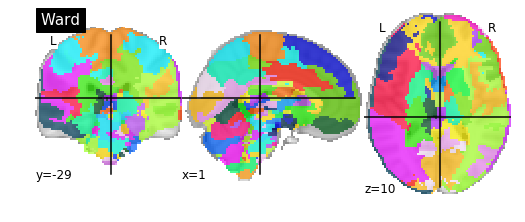

In [15]:
with open("/data/hcp/big_agglomerative_filename.pkl", "rb") as f:  # constants.original_agglomerative_file_name
    ward = pickle.load(f)

ward_img = nibabel.load(constants.ward_parcellation_image)
print(ward_img.shape)
plotting.plot_roi(ward_img, title="Ward")

In [16]:
wtree = constants.get_wtree()
mask = constants.original_brain_mask

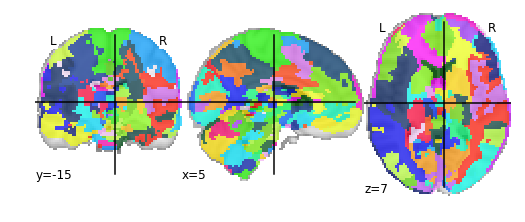

In [19]:
plotting.plot_roi(masking.unmask(1 + wtree.cut(256), mask))

In [17]:
((ward_img.get_data() > 0).astype(int)).sum()

212445

In [18]:
np.unique(ward.labels_).tolist()

[0, 1, 2, 3, 4, 5, 6, 7]

In [19]:
wt = ward_tree.WardTree(ward)

In [20]:
ward.children_.shape

(212444, 2)

212445
16 363587


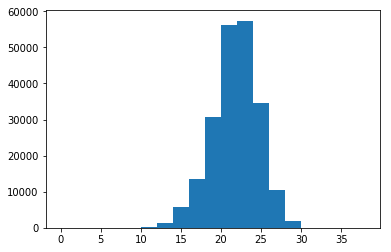

In [21]:
lvs = wt.get_leaves()
depths = [lv.depth for lv in lvs]
print(len(depths))
plt.hist(depths, bins=list(range(0, 40, 2)))
print(lvs[0].depth, lvs[0].parent.val)

In [298]:
level_sizes = [8192, 4096, 2048, 1024, 512, 128]
level_nodes = {len(lvs): lvs}
adjs = {len(lvs): scsp.identity(len(lvs))}
past_lv = lvs
for lvsize in level_sizes:
    start = time.time()
    lv_nodes, lv_adj = ward_tree.go_ up_to_reduce(past_lv, lvsize)
    past_lv = lv_nodes
    level_nodes[lvsize] = lv_nodes
    adjs[lvsize] = lv_adj
    print("level {} took {}s".format(lvsize, time.time() - start))

level 8192 took 1.208733320236206s
level 4096 took 0.0795888900756836s
level 2048 took 0.0356745719909668s
level 1024 took 0.015878677368164062s
level 512 took 0.007853984832763672s
level 128 took 0.004386186599731445s


In [299]:
lv_nodes, adj4096 = ward_tree.go_up_to_reduce(lvs, 4096)


In [310]:
adjs[8192].shape

(8192, 67615)

In [300]:
nds0 = set([k.val for k in level_nodes[4096]])
nds1 = set([k.val for k in lv_nodes])
print(len(nds0), len(nds1), len(nds0.intersection(nds1)))

4096 4096 4096


In [260]:
print(nodes30k[0].depth, nodes30k[10].depth, len(nodes30k))

18 18 30000


In [261]:
print(adj_full_to_30k.nnz, adj_full_to_30k.shape)
print(len(set([nd.val for nd in nodes30k]).intersection(set([nd.val for nd in lvs]))))

67615 (30000, 67615)
21141


135229


(array([3.0000e+00, 1.2000e+01, 4.8000e+01, 1.7400e+02, 6.1400e+02,
        2.1400e+03, 6.1060e+03, 1.2330e+04, 2.2840e+04, 3.3390e+04,
        3.0014e+04, 1.5930e+04, 6.8140e+03, 2.6360e+03, 9.1200e+02,
        4.2800e+02, 2.1800e+02, 1.3200e+02, 6.2000e+01]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38]),
 <a list of 19 Patch objects>)

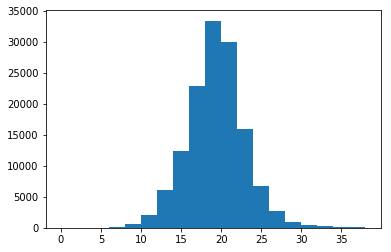

In [203]:
depths = [wt.nodes[k].depth for k in wt.node_idxs]
print(len(depths))
plt.hist(depths, bins=list(range(0, 40, 2)))

In [167]:
[r.val for r in wt.roots]

[135228]

(array([3.0000e+00, 1.2000e+01, 4.8000e+01, 1.7400e+02, 6.1400e+02,
        2.1400e+03, 6.1060e+03, 1.2330e+04, 2.2840e+04, 3.3390e+04,
        3.0014e+04, 1.5930e+04, 6.8140e+03, 2.6360e+03, 9.1200e+02,
        4.2800e+02, 2.1800e+02, 1.3200e+02, 6.2000e+01]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38]),
 <a list of 19 Patch objects>)

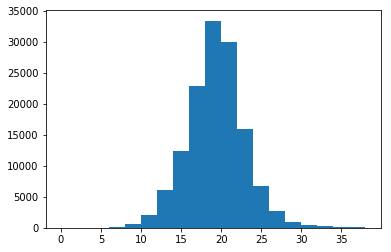

In [49]:
max(depths)

103

In [62]:
pos0 = torch.tensor([[0, 0], [0, 1], [2, 0], [2, 2], [3, 3]]).long()
val0 = torch.randn(pos0.shape[0])
spmat0 = torch.sparse.FloatTensor(pos0.t(), val0)
dense0 = torch.randn(8, spmat0.shape[1], 2)

pos1 = torch.tensor([[0, 1], [0, 2], [3, 3]]).long()
val1 = torch.randn(pos1.shape[0])
spmat1 = torch.sparse.FloatTensor(pos1.t(), val1)
dense1 = torch.randn(8, spmat1.shape[1], 1)

In [63]:
spmat0.to_dense()

tensor([[ 0.0020,  0.9377,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0292,  0.0000, -0.3871,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0738]])

In [65]:
spmat0._indices().t()

tensor([[0, 0],
        [0, 1],
        [2, 0],
        [2, 2],
        [3, 3]])

In [66]:
spmat0._values()

tensor([ 0.0020,  0.9377,  0.0292, -0.3871, -0.0738])

In [67]:
bias = torch.zeros(4, 2)
bias[:, 0] = 1

In [68]:
bias

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [69]:
dense0

tensor([[[ 1.4309, -0.3596],
         [ 0.7275, -0.0497],
         [-0.0471, -0.6583],
         [-3.0942, -0.0359]],

        [[ 0.8693, -0.6713],
         [ 0.2386, -0.6463],
         [-0.3591, -0.7720],
         [ 0.4702,  1.1205]],

        [[-1.4415,  1.1312],
         [ 1.4420, -0.3202],
         [ 0.3680, -1.4719],
         [ 1.5775, -1.1352]],

        [[-0.8015, -0.3194],
         [-0.4397,  0.1473],
         [-0.6651,  0.2997],
         [ 0.8514,  0.1208]],

        [[-3.0438, -1.3618],
         [-0.2004,  0.9265],
         [ 0.0683, -0.3109],
         [-0.7561, -0.8585]],

        [[ 2.8158, -0.8383],
         [-0.7770, -1.7177],
         [ 0.2372, -0.0226],
         [ 0.8715,  1.1737]],

        [[ 0.4638,  0.6788],
         [ 0.7062,  0.2219],
         [ 1.0317, -1.2033],
         [-2.4149, -0.7378]],

        [[-1.6198, -0.6787],
         [ 1.1956, -1.8000],
         [ 0.1666, -0.9068],
         [-0.5896, -0.4818]]])

In [70]:
dense0 + bias

tensor([[[ 2.4309, -0.3596],
         [ 1.7275, -0.0497],
         [ 0.9529, -0.6583],
         [-2.0942, -0.0359]],

        [[ 1.8693, -0.6713],
         [ 1.2386, -0.6463],
         [ 0.6409, -0.7720],
         [ 1.4702,  1.1205]],

        [[-0.4415,  1.1312],
         [ 2.4420, -0.3202],
         [ 1.3680, -1.4719],
         [ 2.5775, -1.1352]],

        [[ 0.1985, -0.3194],
         [ 0.5603,  0.1473],
         [ 0.3349,  0.2997],
         [ 1.8514,  0.1208]],

        [[-2.0438, -1.3618],
         [ 0.7996,  0.9265],
         [ 1.0683, -0.3109],
         [ 0.2439, -0.8585]],

        [[ 3.8158, -0.8383],
         [ 0.2230, -1.7177],
         [ 1.2372, -0.0226],
         [ 1.8715,  1.1737]],

        [[ 1.4638,  0.6788],
         [ 1.7062,  0.2219],
         [ 2.0317, -1.2033],
         [-1.4149, -0.7378]],

        [[-0.6198, -0.6787],
         [ 2.1956, -1.8000],
         [ 1.1666, -0.9068],
         [ 0.4104, -0.4818]]])

In [71]:
spmat0_cuda = spmat0.cuda()

In [72]:
inds = spmat0._indices()
vals = spmat0._values()

In [73]:
spmat0.to_dense()

tensor([[ 0.0020,  0.9377,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0292,  0.0000, -0.3871,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0738]])

In [74]:
inds[0, :]

tensor([0, 0, 2, 2, 3])

In [85]:
dvals = torch.zeros(spmat0.shape[0])

In [86]:
dvals

tensor([0., 0., 0., 0.])

In [87]:
for i in inds[0, :]:
    dvals[i] += 1

In [88]:
dvals

tensor([2., 0., 2., 1.])

In [90]:
spmat0._values().pow(-0.5)

tensor([22.6368,  1.0327,  5.8503,     nan,     nan])

In [96]:
inds + torch.tensor([[6], [6]])

tensor([[6, 6, 8, 8, 9],
        [6, 7, 6, 8, 9]])

In [93]:
inds

tensor([[0, 0, 2, 2, 3],
        [0, 1, 0, 2, 3]])

In [103]:
vals.repeat(2)

tensor([ 0.0020,  0.9377,  0.0292, -0.3871, -0.0738,  0.0020,  0.9377,  0.0292,
        -0.3871, -0.0738])

In [281]:
pos0 = torch.tensor([[0, 0], [0, 1], [2, 0], [2, 2], [3, 3]]).long()
val0 = torch.randn(pos0.shape[0])
spmat0 = torch.sparse.FloatTensor(pos0.t(), val0, size=(10, 10))
dense0 = torch.randn(8, spmat0.shape[1], 2)

pos0 = torch.tensor([[0, 0], [0, 1], [2, 0], [2, 2], [3, 3]]).long()
val0 = torch.randn(pos0.shape[0])
spmat1 = torch.sparse.FloatTensor(pos0.t(), val0, size=(10, 10))
dense1 = torch.randn(8, spmat1.shape[1], 2)


In [106]:
spmat0.shape

torch.Size([10, 10])

In [123]:
import itertools

In [125]:
list(itertools.product([0, 1], [2, 3]))

[(0, 2), (0, 3), (1, 2), (1, 3)]

In [127]:
import scipy.sparse as sp
mat = sp.random(5, 6, 0.1)

In [278]:
mat.shape

(5, 6)

In [136]:
print("row:", mat.row)
print("col:", mat.col)

row: [1 0 4]
col: [0 0 5]


In [137]:
mat.toarray()

array([[0.68015332, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.57571937, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.28928583]])

In [180]:
len(lvs)

67615

In [176]:
depths = [wt.get_depth(i) for i in range(30)]

In [177]:
len(depths)
for d, depth in enumerate(depths):
    print("{}: {} nodes".format(d, len(depth)))

0: 1 nodes
1: 2 nodes
2: 4 nodes
3: 8 nodes
4: 16 nodes
5: 32 nodes
6: 62 nodes
7: 112 nodes
8: 216 nodes
9: 398 nodes
10: 764 nodes
11: 1376 nodes
12: 2408 nodes
13: 3698 nodes
14: 5186 nodes
15: 7144 nodes
16: 9888 nodes
17: 12952 nodes
18: 15842 nodes
19: 17548 nodes
20: 16698 nodes
21: 13316 nodes
22: 9538 nodes
23: 6392 nodes
24: 4166 nodes
25: 2648 nodes
26: 1636 nodes
27: 1000 nodes
28: 586 nodes
29: 326 nodes


In [193]:
adj_lists = {}
for i in range(4, 19):
    start = time.time()
    adj_lists[i] = ward_tree.get_adjacency_list(depths[i], lvs)
    print("depth={} took {}".format(i, time.time() - start))

depth=4 took 83.96622920036316
depth=5 took 83.27551412582397
depth=6 took 83.35431051254272
depth=7 took 83.05302500724792
depth=8 took 83.47034907341003
depth=9 took 83.02045369148254
depth=10 took 83.02043962478638
depth=11 took 82.8228132724762
depth=12 took 81.57631015777588
depth=13 took 80.05318903923035
depth=14 took 77.08064389228821
depth=15 took 73.6648154258728
depth=16 took 68.95127820968628
depth=17 took 62.47434592247009
depth=18 took 53.41191053390503


In [192]:
print([i for i in range(len(adj19_to_leaves)) if len(adj19_to_leaves[i])==0])

[]


In [251]:
len(nodes_pq)

30000

In [285]:
spmat0.to_dense()

tensor([[ 1.0424, -0.4531,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.6439,  0.0000,  0.7847,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.9316,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

In [284]:
spmat1.to_dense()

tensor([[-1.3172, -1.0059,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.0960,  0.0000,  0.3038,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.8388,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

In [286]:
spmat0 + spmat1

tensor(indices=tensor([[0, 0, 2, 2, 3],
                       [0, 1, 0, 2, 3]]),
       values=tensor([-0.2749, -1.4591,  2.7399,  1.0885, -1.7704]),
       size=(10, 10), nnz=5, layout=torch.sparse_coo)

In [291]:
nilearn.masking.apply_mask(ward_img, constants.brain_mask).shape

(67615,)

# Method 2 - Treat input as embedding matrix

In [315]:
isinstance(, sp.coo_matrix)

True

In [316]:
scspmat = sp.rand(4, 5, 0.1)

In [326]:
scspmat.col

array([3, 4], dtype=int32)

In [327]:
a = np.random.rand(4, 3)
b = np.random.rand(3,)

In [332]:
c = np.matmul(a, np.reshape(b, (-1, 1)))

In [333]:
w = np.random.rand(1, 5)

In [334]:
d = np.matmul(c, w)

In [335]:
d.shape

(4, 5)

In [394]:
# UNIT TEST
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

import data.constants as constants
args = dotdict()
args.device = 'cpu'
args.meta = {}
args.meta['s2i'] = {"sa": 0, "sb": 1,}
args.meta['t2i'] = {"taa": 0, "tab": 1, "tba": 2, "tbb": 3, "tbc": 4}
args.meta['c2i'] = {"caaa": 0, "caab": 1, "caba": 2, "cabb": 3, "cbaa": 4, "cbab": 5, "cbba": 6, "cbbb": 7, "cbca": 8, "cbcb": 9,}
args.meta['si2ti'] = {
    0: [0, 1],
    1: [2, 3, 4],
}
args.meta['ti2ci'] = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9],
}
args.wtree = wt
args.nregions = 8

In [409]:
clf = classifiers.versions['0'](args)
clf = clf.cuda()

In [410]:
start = time.time()
cpred = clf(torch.randn(32, 67615).cuda())
print("Took {}s".format(time.time() - start))

Took 0.02557206153869629s


In [413]:
import argparse
import pdb
import os
import time
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gcn.modules.fgl as fgl
import gcn.toy.dataset as dset
import torch.optim as optim
import scipy.sparse as sp
import utils.utils as utils
class FGLNet(nn.Module):
    def __init__(self, midc, adj_list, *args, **kwargs):
        super(FGLNet, self).__init__()
        self.net = nn.Sequential(
            fgl.FGL(3, 784, midc, len(adj_list), adj_list),
            nn.Tanh(),
        )
        self.linear = nn.Sequential(
            nn.Linear(len(adj_list) * midc, dset.ydim[0]),
        )  # Softmax on top

    def forward(self, x):
        cur = x
        cur = self.net(cur).view(x.shape[0], -1)
        return self.linear(cur)
class Baseline(nn.Module):
    def __init__(self, cs, *args, **kwargs):
        super(Baseline, self).__init__()
        self.cs = cs
        self.net = []
        for i in range(0, len(cs) - 1):
            self.net.extend([nn.Linear(cs[i], cs[i+1]), nn.Tanh()])
        self.net.extend([nn.Linear(cs[-1], 8)])
        self.net = nn.Sequential(*(self.net))

    def forward(self, x):
        # x: N * xdim[0], xdim[1]
        cur = x.view(x.shape[0], -1)
        # with torch.autograd.profiler.profile(use_cuda=True) as prof:
        for module in self.net:
            cur = module(cur)
        # print(prof)
        return cur  # N, 8


arch_dict = {
    'baseline': lambda ks, As: Baseline(ks),
    'fgl': lambda ks, As: FGLNet(ks, As),
}

args = dotdict()
args.device = 'cpu'
args.datafile = "/data/gcn_toy/data_n10000_seed1337_hxd0.01_hn0.05_xn0.05.npz"
args.split_fraction = 0.8
args.batch_size = 32
args.num_workers = 1
args.intermediate_channel = 10

train_dset, test_dset = dset.load_train_test(args.datafile, args.split_fraction)
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=True,
)

As = []
base_As = train_dset.Ahx
for ridx in range(base_As.shape[0]):
    As.append([ridx])
    for cidx in range(base_As.shape[1]):
        if base_As[ridx, cidx] > 0:
            As[-1].append(cidx)
ks = args.intermediate_channel
model = arch_dict['fgl'](ks, As)

In [421]:
[i for i in range(128) if model.net[0].A[i][-1] != 0 ]

[29, 84, 119]

In [422]:
model.net[0].A[29]

tensor([ 29,  52,  78, 133, 142, 166, 207, 271, 435, 453, 558, 574, 616, 632,
        690])

In [17]:
def get_3d_convolution_adjacency(input_volume, kernel_sizes, strides, paddings):
    # input_volume: an (3) dimensional volume, represented as a list.
    # input_volume[i][j][k] = -1 if its not a valid location
    # input_volume[i][j][k] = i if its a valid location
    # output_volume[i'][j'][k'] follows the same convention.
    # adjacency is from valid positions to valid positions
    if not(isinstance(kernel_sizes, list)):
        kernel_sizes = [kernel_sizes, kernel_sizes, kernel_sizes]
    if not(isinstance(strides, list)):
        strides = [strides, strides, strides]
    if not(isinstance(paddings, list)):
        paddings = [paddings, paddings, paddings]

    inD = len(input_volume)
    inH = len(input_volume[0])
    inW = len(input_volume[0][0])
    # Compute new I, J, K
    outD = math.floor(1 + (inD + 2 * paddings[0] - kernel_sizes[0]) / strides[0])
    outH = math.floor(1 + (inH + 2 * paddings[1] - kernel_sizes[1]) / strides[1])
    outW = math.floor(1 + (inW + 2 * paddings[2] - kernel_sizes[2]) / strides[2])

    output_volume = [[[-1 for _ in range(outW)] for _ in range(outH)] for _ in range(outD)]

    adjacency = []
    for d in range(outD):
        for h in range(outH):
            for w in range(outW):
                dependecies = []
                mind_ = max(0, d * strides[0] - kernel_sizes[0] // 2)
                maxd_ = min(inD, 1 + d * strides[0] + kernel_sizes[0] // 2)
                minh_ = max(0, h * strides[1] - kernel_sizes[1] // 2)
                maxh_ = min(inH, 1 + h * strides[1] + kernel_sizes[1] // 2)
                minw_ = max(0, w * strides[2] - kernel_sizes[2] // 2)
                maxw_ = min(inW, 1 + w * strides[2] + kernel_sizes[2] // 2)
                for d_ in range(mind_, maxd_):
                    for h_ in range(minh_, maxh_):
                        for w_ in range(minw_, maxw_):
                            if input_volume[d_][h_][w_] != -1:
                                dependecies.append(input_volume[d_][h_][w_])
                if len(dependecies) > 0:
                    output_volume[d][h][w] = len(adjacency)
                    adjacency.append(dependecies)
    return output_volume, adjacency

In [18]:
iv = [[[-1 for _ in range(10)] for _ in range(10)] for _ in range(10)]
iv[5][5][5] = 0
ov, A = get_3d_convolution_adjacency(iv, 3, 1, 1)

In [20]:
len(A)

27

In [25]:
mask = nibabel.load("/data/hcp/hcp_mask.nii.gz")
continuous = np.array([i for i in range(np.prod(mask.shape))])
continuous_image = nibabel.Nifti1Image(np.reshape(continuous, mask.shape), mask.affine)

In [28]:
masking.apply_mask(continuous_image, mask)

array([103046., 103047., 103048., ..., 788816., 788817., 788818.],
      dtype=float32)

In [29]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])
is_sorted(masking.apply_mask(continuous_image, mask))

True

In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from clevr import dataset as clevr_dset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dset = clevr_dset.SomewhatClevr()

Text(0.5,1,'quadrant=0')

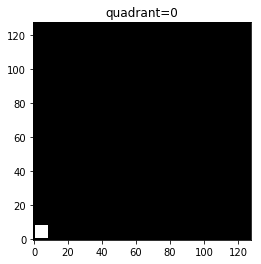

In [19]:
img, q = dset[0]
plt.imshow(img, cmap='gray', origin='lower')
plt.title("quadrant={}".format(q))